# Tutorial

## Author: Jisheng Zhang

This tutorial provides an example simulation by CMAPPER (based on the code developed by `Zhang & Rogers 2022`). CMAPPER is a 1D code to simulate thermal evolution of rocky planets, assuming an arbitrary hot initial state (fully melted Fe core and magma ocean) upon differentiation. The simulation with the default combination of parameters (values provided in `input.txt`) should output the same result as what is shown in this notebook.

The notebook also provides routines users can adopt or modify to visualize the output. These routines can also be found in the file `test.py`, in which we use some of the routines to generate plots and movies saved in the folder `image` and `movie`.

#### All units are in SI unit unless otherwise noted

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8')
import numpy as np

In [4]:
# save_t is a list of timesteps in years at which 
# planet thermal and structural profiles are saved
# in the following folder:
# '/results_Mpl#_CMF#_time#_Qrad#_#_#_#_Teq#'  
# with # being values in the file `input.txt`for
# the variable preceding them

save_t=[1.0]
for i in range(1,182):
    if save_t[i-1]<5000.0:
        save_t.append(save_t[i-1]+80.0)
    elif save_t[i-1]<1e8 and save_t[i-1]>=5000.0:
        save_t.append(save_t[i-1]+int(save_t[i-1]/3.0))
    elif save_t[i-1]>=1e8 and save_t[i-1]<1e9:
        save_t.append(save_t[i-1]+int(save_t[i-1]/10.0))
    else:
        save_t.append(save_t[i-1]+int(save_t[i-1]/25.0))

In [47]:
save_t_title=save_t.copy()
t_title=[]
for i in range(len(save_t)):
    if save_t[i]<100.0 and save_t[i]>1.0:
        save_t_title[i]=save_t_title[i]-1.0
    elif save_t[i]>=100.0 and save_t[i]<10000.0:
        round_value=round(save_t[i], -2)
        save_t_title[i]=round_value
    else:
        round_value=round(save_t[i], -len(str(int(save_t[i])))+2)
        save_t_title[i]=round_value

    if save_t_title[i]<1000.0:
        if save_t[i]==1.0:
            t_title.append('time: '+str(int(save_t_title[i]))+' year')
        t_title.append('time: '+str(int(save_t_title[i]))+' years')
    elif save_t_title[i]>=1000.0 and save_t_title[i]<1000000.0:
        t_title.append('time: '+str((save_t_title[i])/1000.0)+' kyr')
    elif save_t_title[i]>=1000000.0 and save_t_title[i]<1000000000.0:
        t_title.append('time: '+str((save_t_title[i])/1000000.0)+' Myr')
    elif save_t_title[i]>=1000000000.0 and save_t_title[i]<1000000000000.0:
        t_title.append('time: '+str((save_t_title[i])/1000000000.0)+' Gyr')
    st=t_title[i]
    if len(t_title[i])==11:
        t_title[i]='  '+st
    elif len(t_title[i])==12:
        t_title[i]=' '+st

In [216]:
def f_axis_max_min(v_min,v_max,axis_scale):
    if axis_scale=='log':
        v_max=np.log10(v_max)
        v_min=np.log10(v_min)
        dv=np.abs(v_max-v_min)/10.0
        v_max=10.0**(v_max+dv)
        v_min=10.0**(v_min-dv)
    else:
        dv=np.abs(v_max-v_min)/10.0
        v_max=v_max+dv
        v_min=v_min-dv
    return v_min,v_max

In [4]:
evo=np.loadtxt('results/evolution.txt')
# index  variable  #### everything is in SI units
# 0       t
# 1       dt
# 2       average mantle specific entropy
# 3       average mantle temperature
# 4       average core temperature 
# 5       surface temperature
# 6       core mantle boundary (CMB) temperature
# 7       surface heat flux
# 8       CMB flux
# 9       Conductive flux along core adiabat (threshold flux for thermal convection in liquid core)
# 10      Planet radius
# 11      Core radius
# 12      Central pressure
# 13      CMB pressure

## pick values for i_x and i_y in the following boxes to set x and y-axis to plot thermal history of the planet

Text(0.5, 0, 'Gyr')

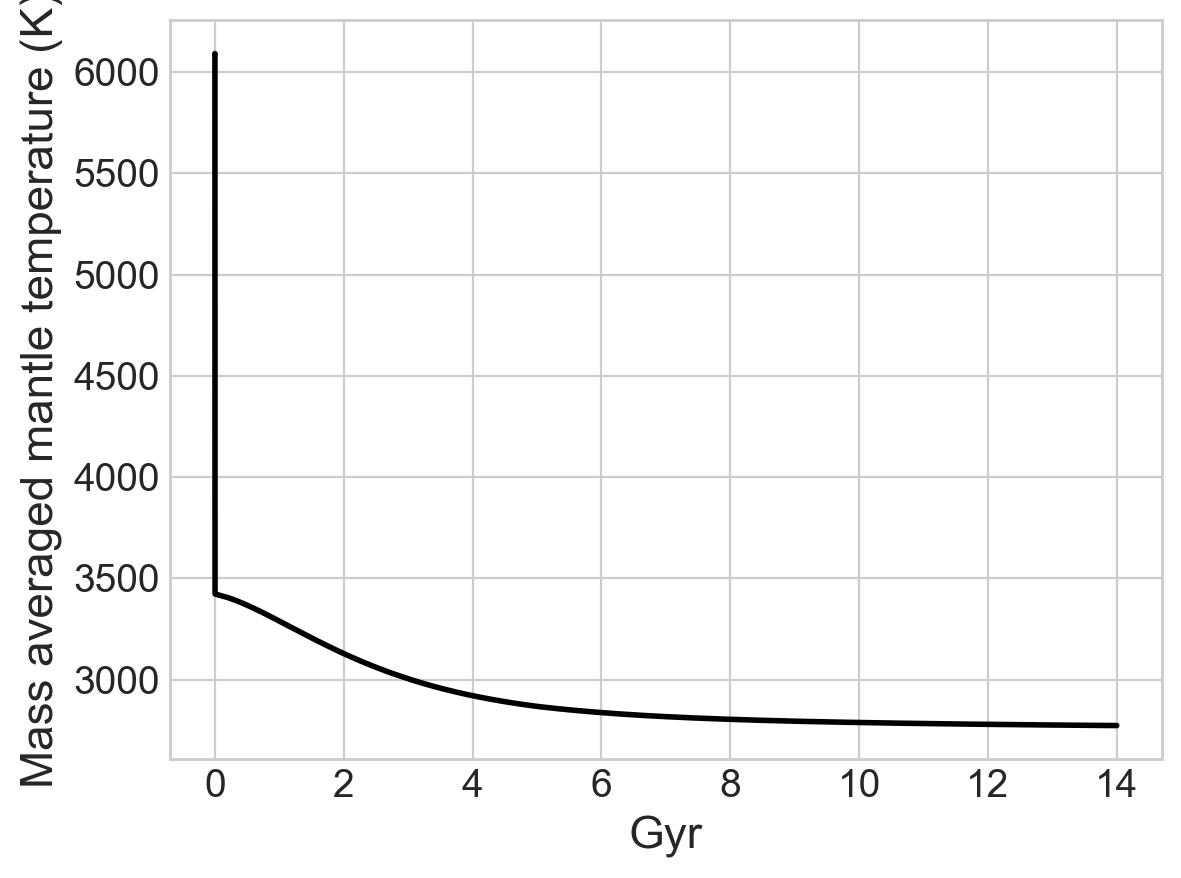

In [6]:
i_x=0
i_y=3
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Mass averaged mantle temperature (K)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

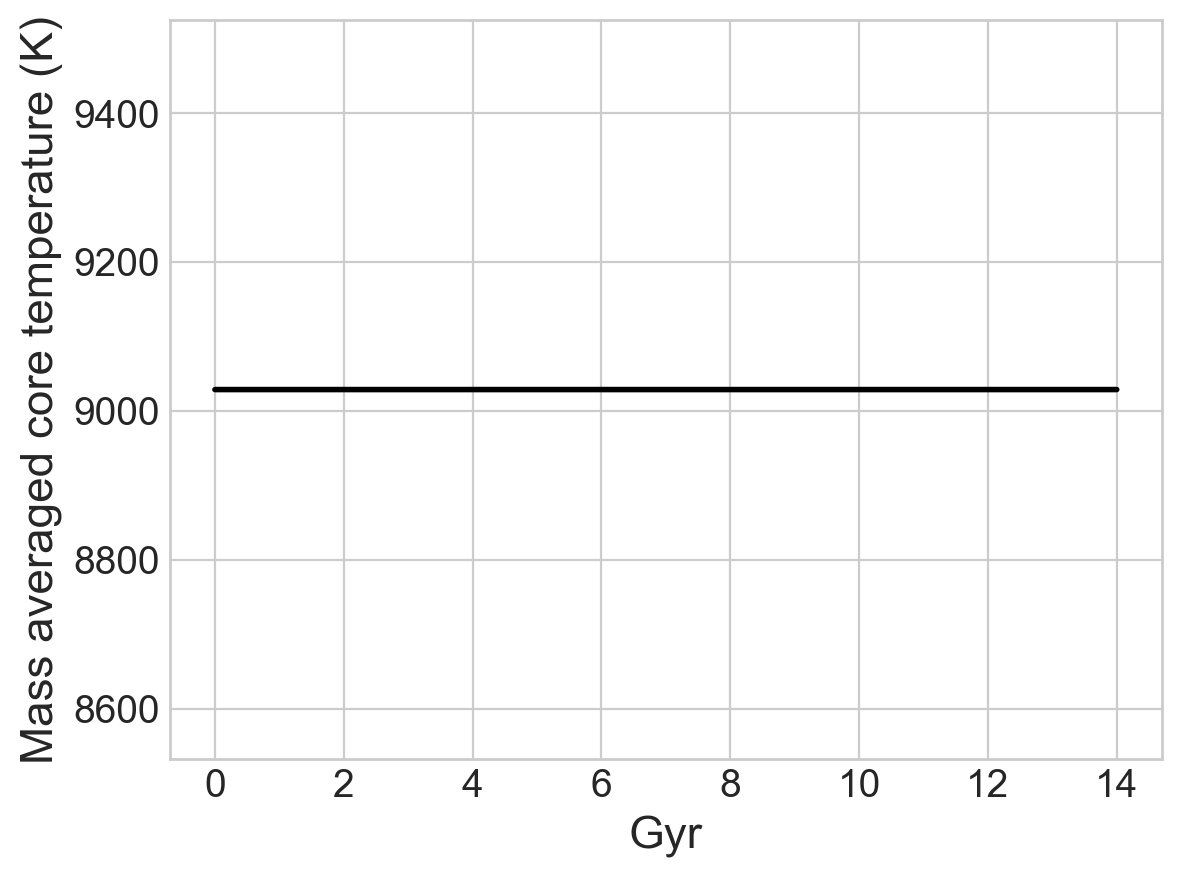

In [7]:
i_x=0
i_y=4
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Mass averaged core temperature (K)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

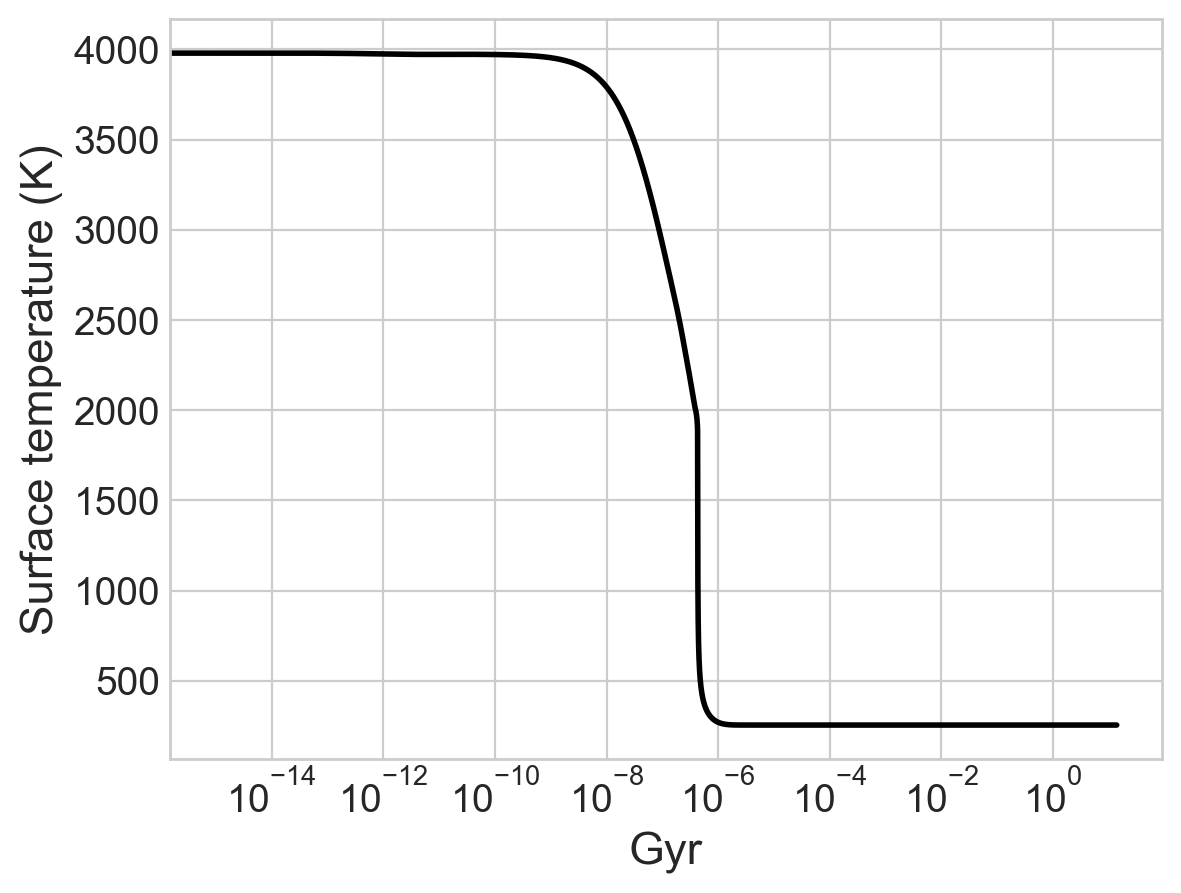

In [48]:
i_x=0
i_y=5
plt.xscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Surface temperature (K)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

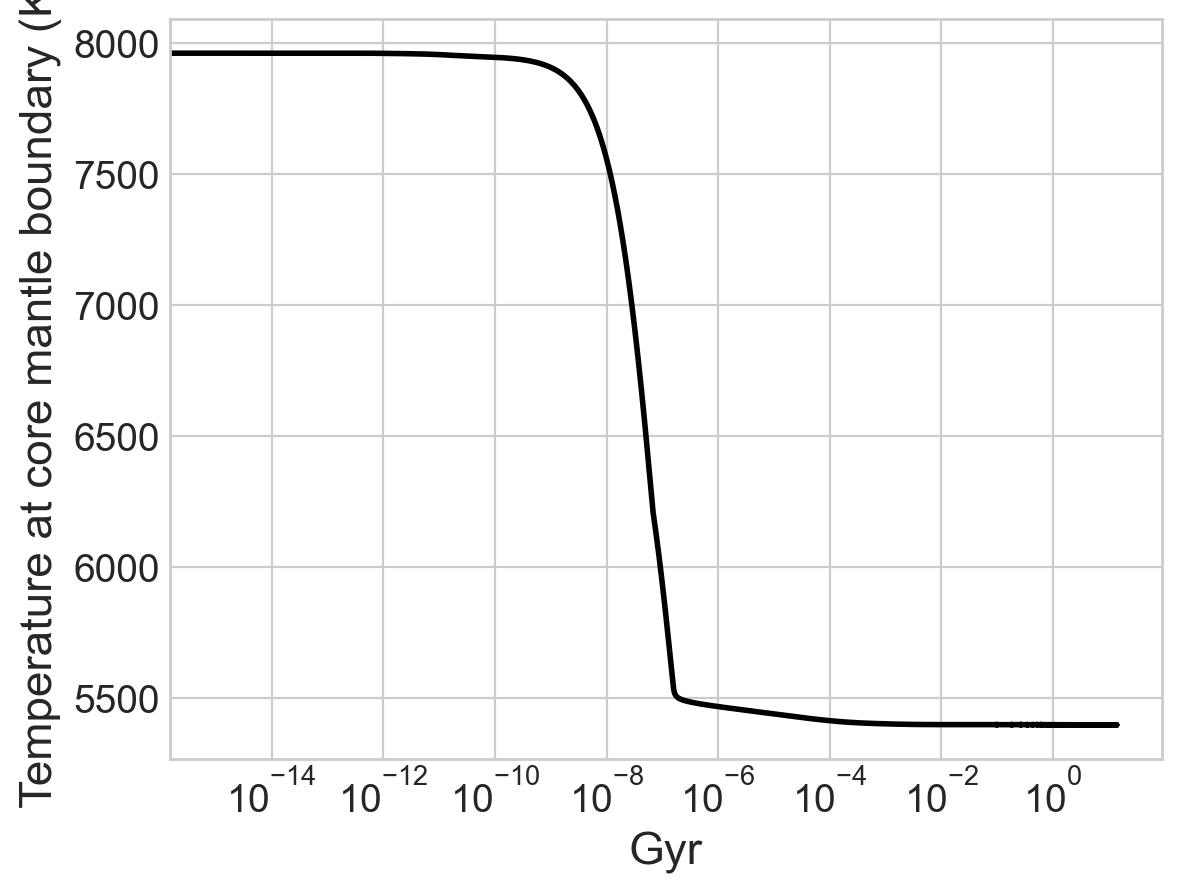

In [12]:
i_x=0
i_y=6
plt.xscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Temperature at core mantle boundary (K)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

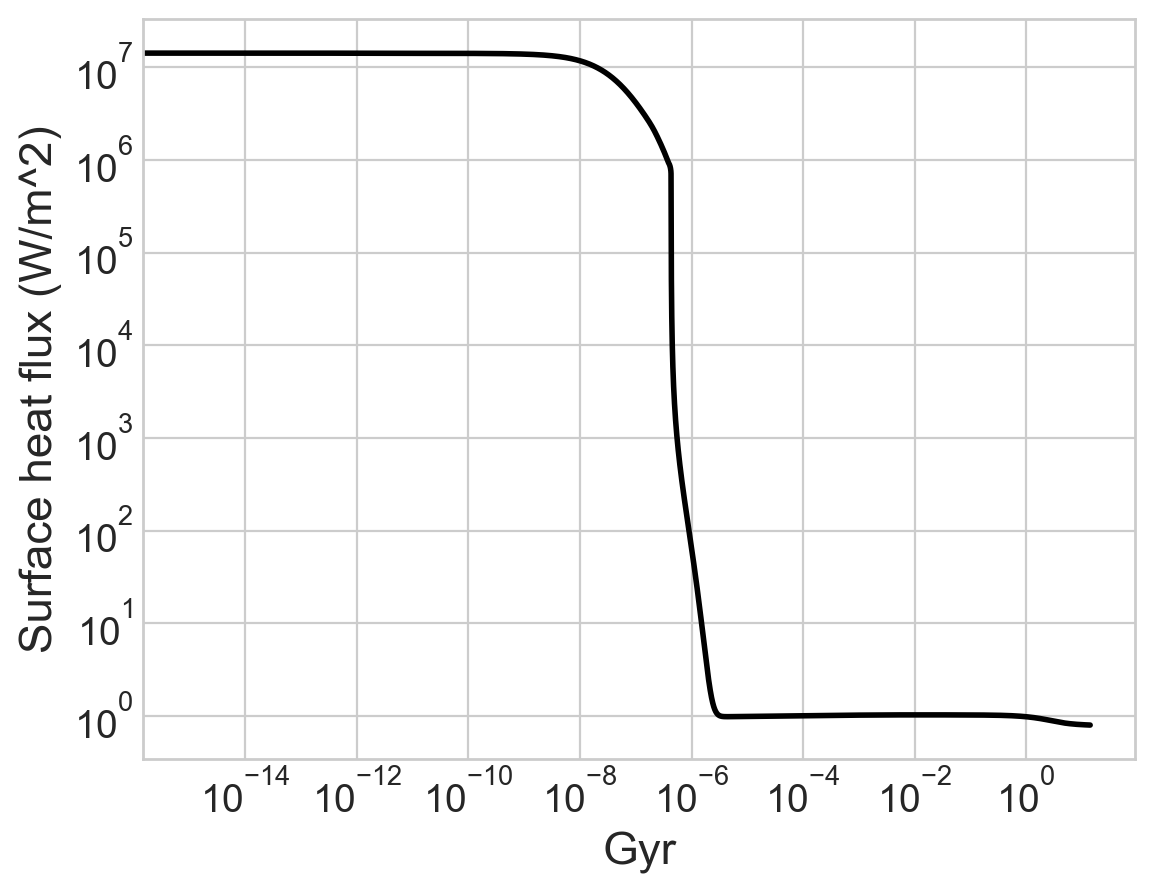

In [16]:
i_x=0
i_y=7
plt.xscale('log')
plt.yscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Surface heat flux (W/m^2)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

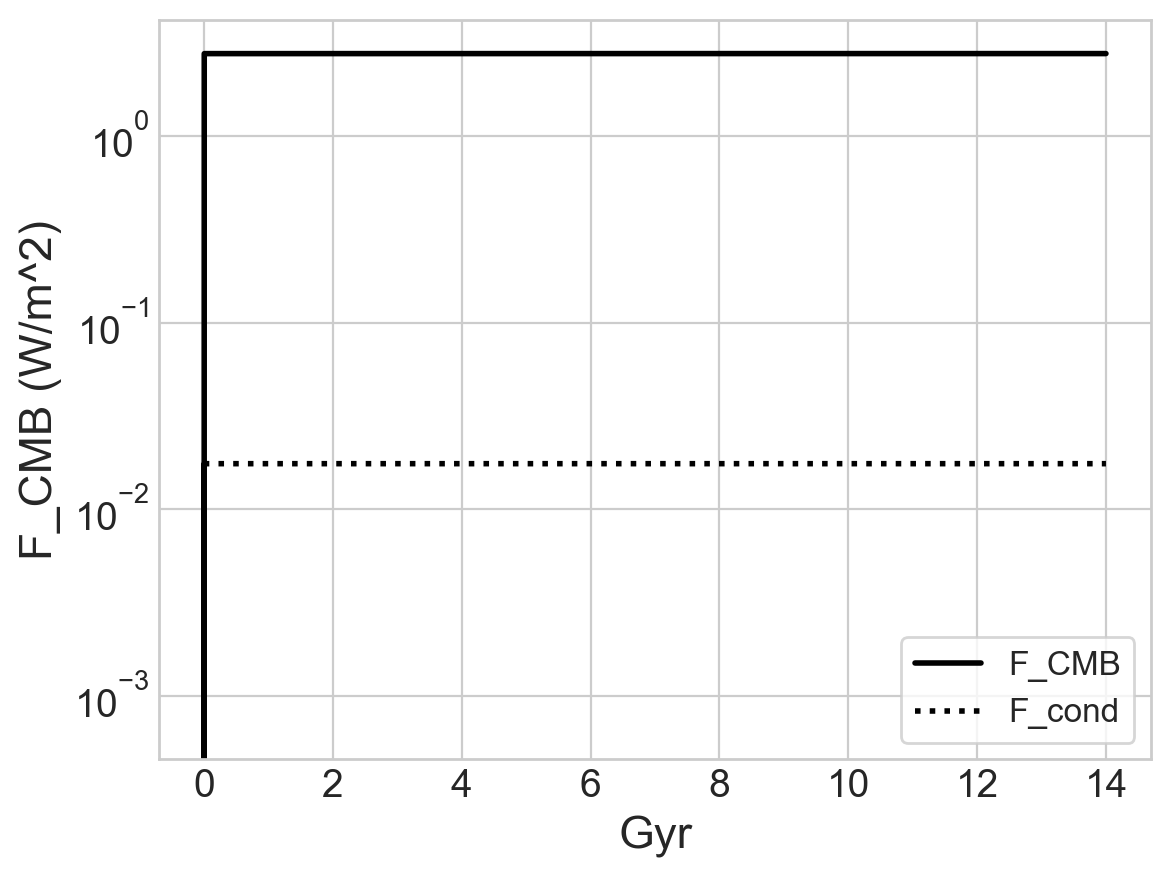

In [19]:
i_x=0
i_y=8
plt.yscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0,label='F_CMB')
i_y=9
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0,linestyle=':',label='F_cond')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('F_CMB (W/m^2)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 
plt.legend(frameon=True, fontsize=12)

Text(0.5, 0, 'Gyr')

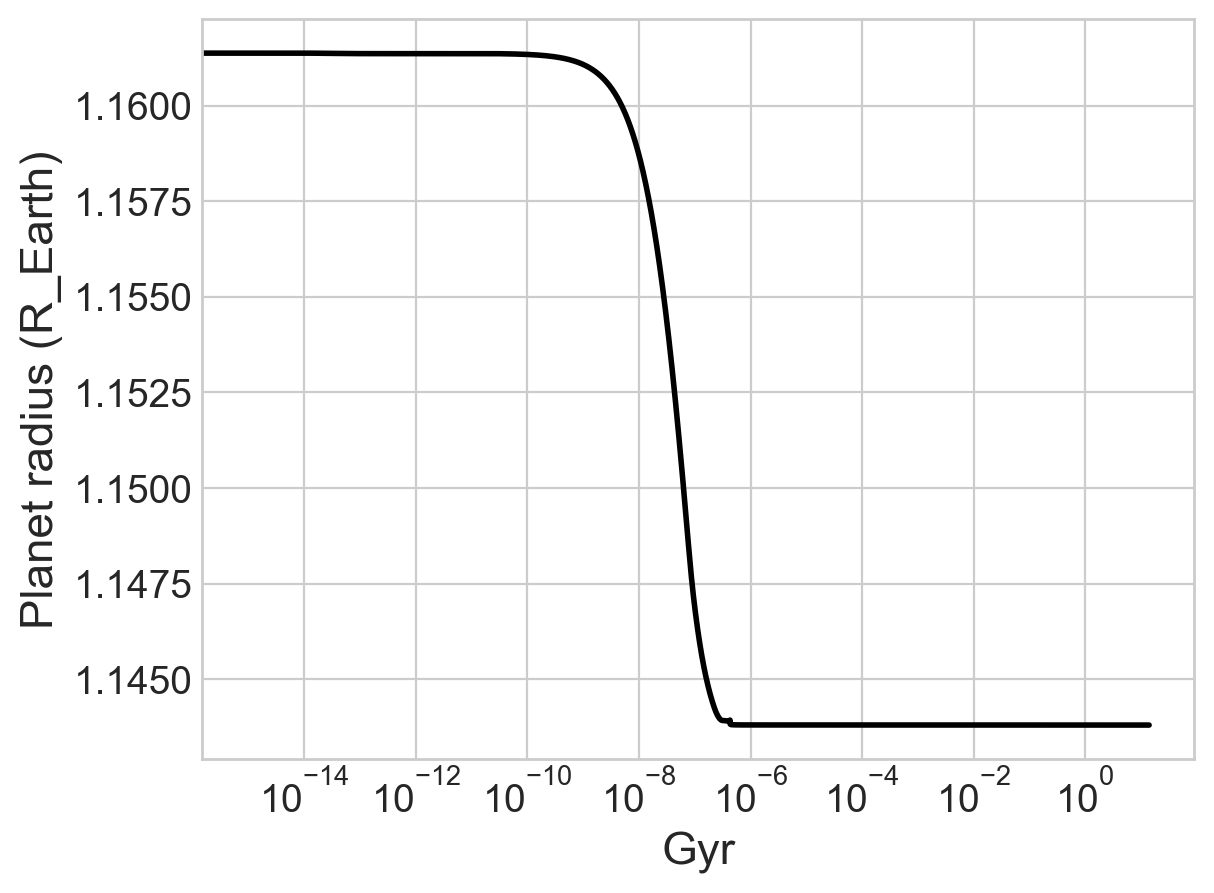

In [21]:
i_x=0
i_y=10
plt.xscale('log')
#plt.yscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y]/6371000.0,color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Planet radius (R_Earth)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

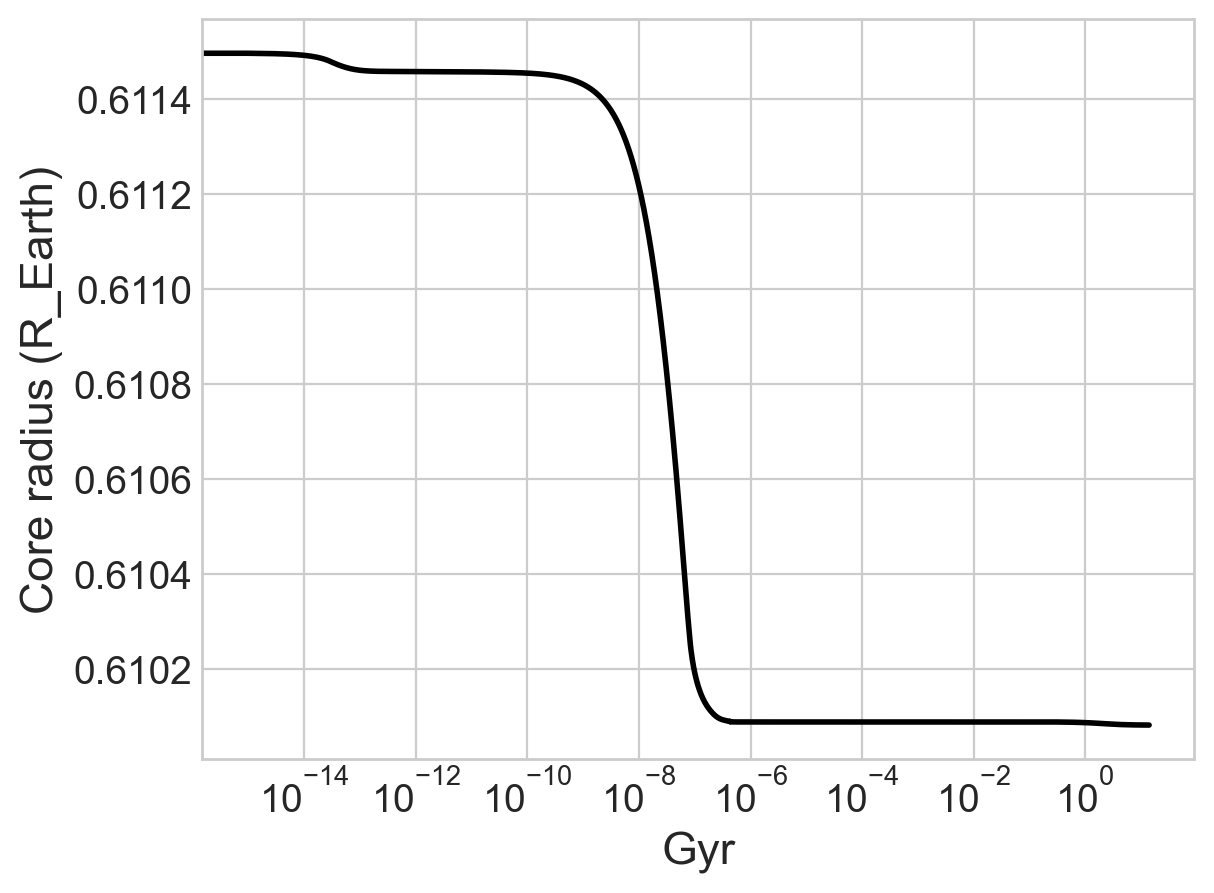

In [22]:
i_x=0
i_y=11
plt.xscale('log')
#plt.yscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y]/6371000.0,color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Core radius (R_Earth)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

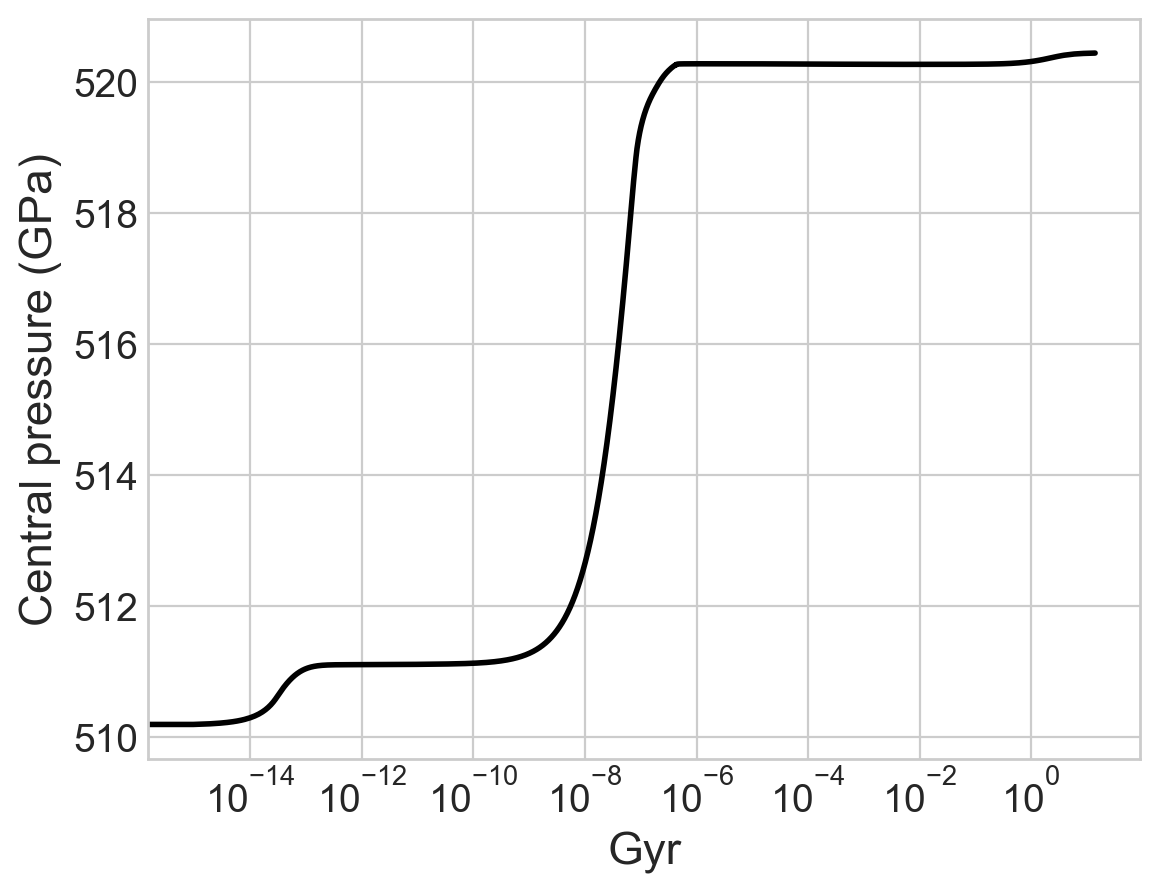

In [23]:
i_x=0
i_y=12
plt.xscale('log')
#plt.yscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y]/1e9,color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Central pressure (GPa)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

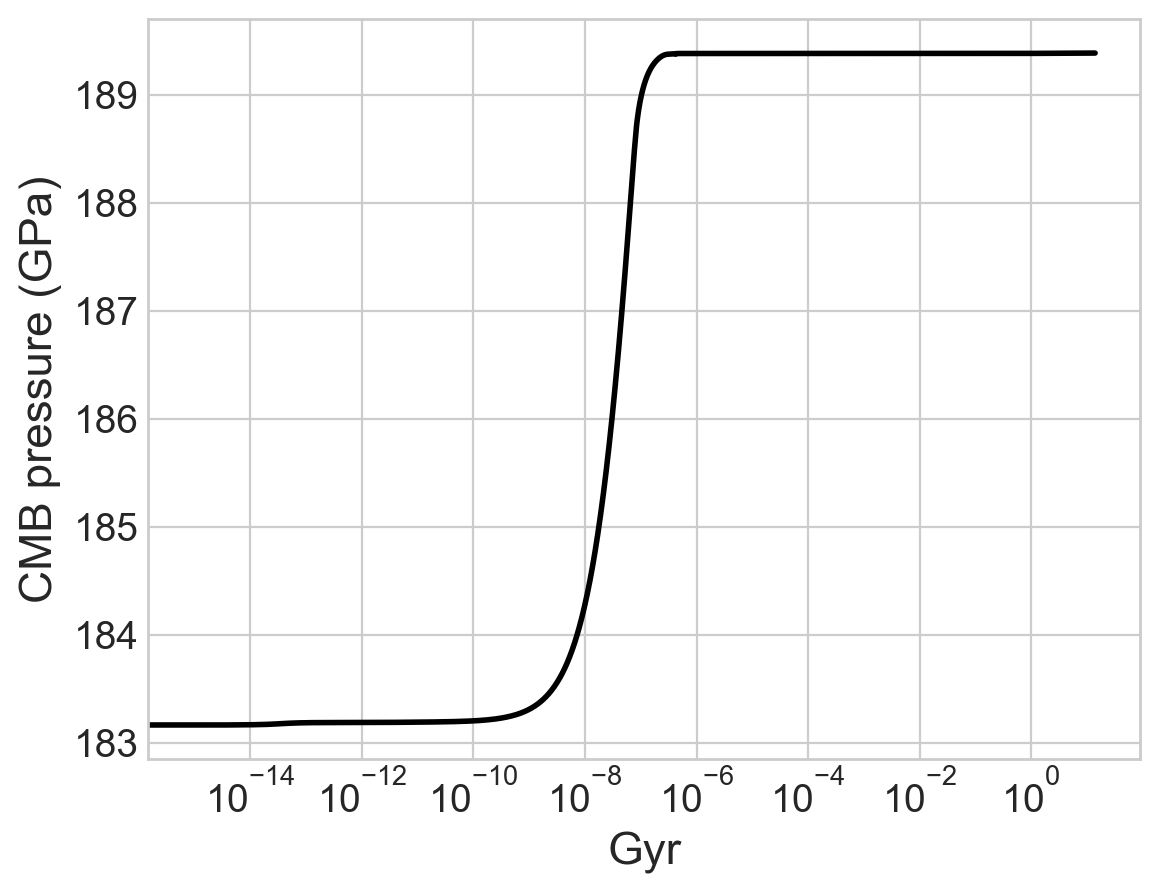

In [24]:
i_x=0
i_y=13
plt.xscale('log')
#plt.yscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y]/1e9,color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('CMB pressure (GPa)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

In [25]:
# timesteps (years) for which profiles are saved

save_t=[1.0]
for i in range(1,1000):
    if save_t[i-1]<10000.0:
        save_t.append(save_t[i-1]+20.0)
    elif save_t[i-1]<1e8:
        save_t.append(save_t[i-1]+int(save_t[i-1]/20.0))
    else:
        save_t.append(save_t[i-1]+int(save_t[i-1]/50.0))

In [26]:
ind=500 # select a timestep out of save_t
s=np.loadtxt('results/profile/structure_'+str(int(save_t[ind]))+'.txt')
p=np.loadtxt('results/profile/property_'+str(int(save_t[ind]))+'.txt')

### everything is in SI units.
####### s file 
# index   variable
# 0       radius
# 1       pressure
# 2       temperature
# 3       density
# 4       gravity
# 5       mass
####### p file
# index   variable
# 0       thermal expansion coefficient 
# 1       specific heat
# 2       gravity
# 3       Convective flux in the mantle
# 4       Convective velocity in the mantle
# 5       Magnetic Reynolds number
# 6.      viscosity

# pick i_x and i_y and s/p files to set x and y-axis in the following boxes to plot thermal and structural profiles

Text(0.5, 0, 'Gyr')

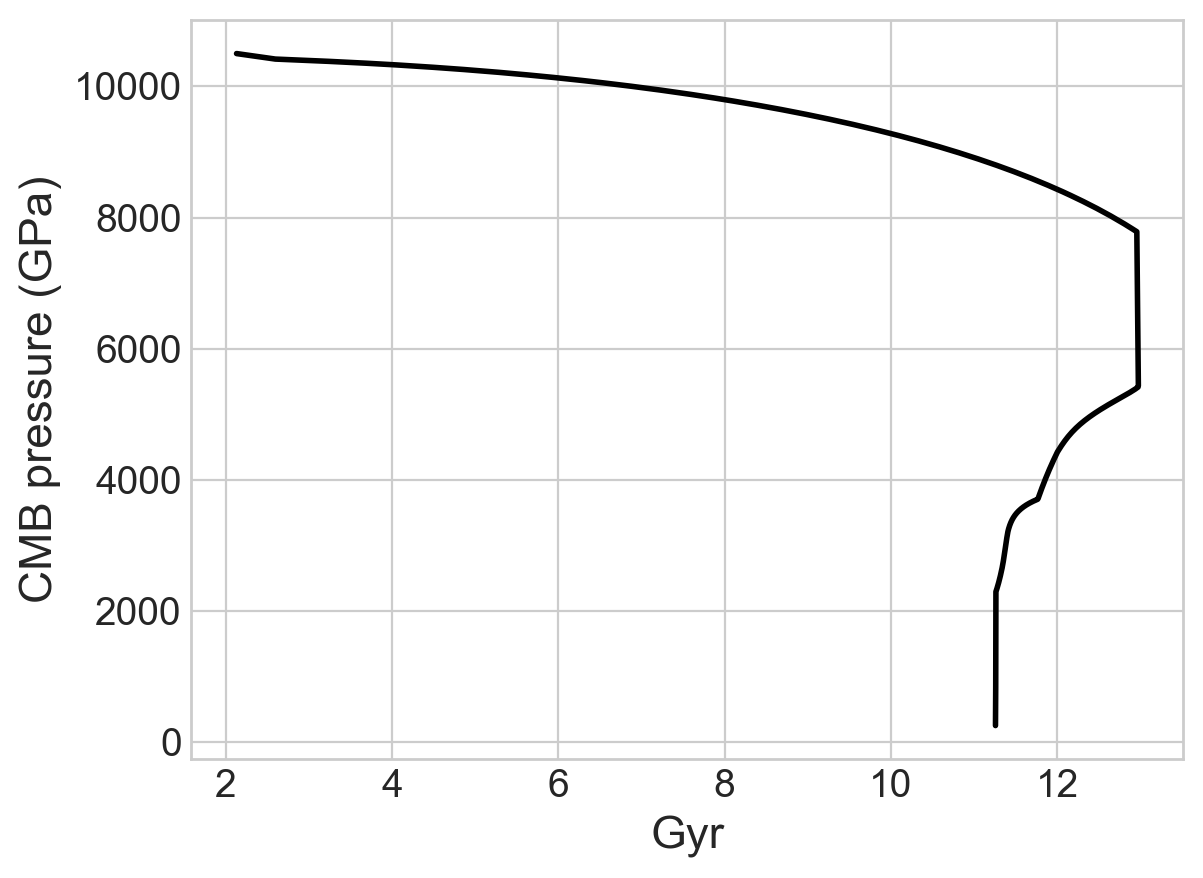

In [37]:
i_x=0
i_y=2
plt.plot(s[:,-1],s[:,i_y],color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('CMB pressure (GPa)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 